## データ型の確認をする

In [32]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_clipped_outliers_ChildCount.csv'
train_data = pd.read_csv(data_path, low_memory=False, dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})

# データ型の確認
print("Data types of each column:\n", train_data.dtypes)

# 数値型の列を取得
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:\n", numerical_cols)

Data types of each column:
 Age                        int64
TypeofContact             object
CityTier                   int64
DurationOfPitch            int64
Occupation                object
Gender                    object
NumberOfPersonVisiting     int64
NumberOfFollowups          int64
ProductPitched            object
PreferredPropertyStar      int64
NumberOfTrips              int64
Passport                   int64
PitchSatisfactionScore     int64
Designation               object
MonthlyIncome              int64
ProdTaken                  int64
MaritalStatus              Int64
CarCount                   Int64
ChildCount                 Int64
dtype: object
Numerical columns:
 Index(['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'MonthlyIncome', 'ProdTaken',
       'MaritalStatus', 'CarCount', 'ChildCount'],
      dtype='object')


In [33]:
print(train_data['Age'].nunique())
print(train_data['MonthlyIncome'].nunique())


44
2200


## 必要な場合、特徴量の統計情報を確認する
新しい特徴量を作成するときに値が0になる場合があります。必要に応じて確認をしています。

In [16]:
import pandas as pd
import numpy as np
import os

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_clipped_outliers_ChildCount.csv'
train_data = pd.read_csv(data_path, low_memory=False, 
                         dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})


print(train_data['NumberOfPersonVisiting'].describe())


count    2989.000000
mean        2.375042
std         0.725464
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: NumberOfPersonVisiting, dtype: float64


## 目的変数を使用せず新しい特徴量を作成する

In [17]:
import pandas as pd
import numpy as np
import os

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_clipped_outliers_ChildCount.csv'
train_data = pd.read_csv(data_path, low_memory=False, 
                         dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})

# 1. 家族のサイズを示す変数を作成
# MaritalStatusが1（既婚）なら配偶者を含める
train_data['FamilySize'] = 1 + train_data['ChildCount'] + train_data['MaritalStatus'].apply(lambda x: 1 if x == 1 else 0)

# 2. Age と MonthlyIncome の相互作用特徴量
train_data['Age_MonthlyIncome_Interaction'] = train_data['Age'] * train_data['MonthlyIncome']

# 3. Age と MonthlyIncome のバケット化
train_data['Income_Bucket'] = pd.cut(
    train_data['MonthlyIncome'], 
    bins=[0, 250000, 300000, 350000, 400000, 450000, np.inf], 
    labels=['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh', 'UltraHigh']
)

train_data['Age_Bucket'] = pd.cut(
    train_data['Age'], 
    bins=[0, 20, 30, 40, 50, 60, np.inf], 
    labels=['VeryYoung', 'Young', 'Middle', 'MiddleOld', 'Old', 'VeryOld']
)

# Age_Bucket と Income_Bucket の相互作用特徴量を作成
train_data['Age_Income_Interaction'] = train_data['Age_Bucket'].astype(str) + '_' + train_data['Income_Bucket'].astype(str)
# 各ビンに含まれるデータポイント数を確認
Income_Age_Bucket_bin_counts = train_data['Income_Bucket'].value_counts().sort_index()
# 結果を表示
print(Income_Age_Bucket_bin_counts)

# 4. DurationOfPitch のビン分割
train_data['DurationOfPitch_Category'] = pd.cut(train_data['DurationOfPitch'], 
    bins=[0, 400, 800, 1000, np.inf], labels=['Short', 'Medium', 'Long', 'VeryLong'])
# 各ビンに含まれるデータポイント数を確認
DurationOfPitch_Category_bin_counts = train_data['DurationOfPitch_Category'].value_counts().sort_index()
# 結果を表示
print(DurationOfPitch_Category_bin_counts)

# 5. Age x DurationOfPitch
train_data['Age_DurationOfPitch'] = train_data['Age'] * train_data['DurationOfPitch']

# 6. CityTier x Age
train_data['CityTier_Age'] = train_data['CityTier'] * train_data['Age']

# 7. CityTier x MonthlyIncome
train_data['CityTier_MonthlyIncome'] = train_data['CityTier'] * train_data['MonthlyIncome']

# 8. MonthlyIncome / FamilySize
train_data['MonthlyIncome_PerFamily'] = train_data['MonthlyIncome'] / train_data['FamilySize']

# 9. 年齢と収入の比率:
train_data['Income_Per_Age'] = train_data['MonthlyIncome'] / train_data['Age']

# 10. PitchSatisfactionScore / NumberOfPersonVisiting
train_data['Satisfaction_PerVisitor'] = train_data['PitchSatisfactionScore'] / train_data['NumberOfPersonVisiting']

# 年代別にグループ化して平均を計算
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=[0, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 100],
                                labels=['0-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+'])

# 年代別の平均収入を計算
age_group_avg_income = train_data.groupby('AgeGroup', observed=False)['MonthlyIncome'].mean().reset_index()
age_group_avg_income.columns = ['AgeGroup', 'AverageIncome']

# 元のデータに新しい特徴量として追加
train_data = pd.merge(train_data, age_group_avg_income, on='AgeGroup', how='left')

# 作成した11の特徴量リスト
created_features = [
    'FamilySize',
    'Age_MonthlyIncome_Interaction',
    'Income_Bucket',
    'Age_Bucket',
    'Age_Income_Interaction',
    'DurationOfPitch_Category',
    'Age_DurationOfPitch',
    'CityTier_Age',
    'CityTier_MonthlyIncome',
    'MonthlyIncome_PerFamily',
    'Income_Per_Age',
    'Satisfaction_PerVisitor',
    'AgeGroup',
    'AverageIncome'  # 年代別の平均収入
]

# データセットに含まれているかを確認
missing_features = [feature for feature in created_features if feature not in train_data.columns]

if missing_features:
    print(f"以下の特徴量がデータセットに含まれていません: {missing_features}")
else:
    print("すべての特徴量がデータセットに含まれています。")

# データフレームの先頭を表示して確認（オプション）
print(train_data.dtypes)

# ディレクトリが存在するか確認し、存在しない場合は作成
save_dir = '/Users/hayakawakazue/Downloads/signate/train'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# データを保存
train_data_path = os.path.join(save_dir, 'train_new_features_without_target.csv')
train_data.to_csv(train_data_path, index=False)

print(f"新しい特徴量を作成しデータを保存しました: {train_data_path}")


Income_Bucket
VeryLow       34
Low          746
Medium       895
High         701
VeryHigh     284
UltraHigh    329
Name: count, dtype: int64
DurationOfPitch_Category
Short         96
Medium      1676
Long         759
VeryLong     458
Name: count, dtype: int64
すべての特徴量がデータセットに含まれています。
Age                                 int64
TypeofContact                      object
CityTier                            int64
DurationOfPitch                     int64
Occupation                         object
Gender                             object
NumberOfPersonVisiting              int64
NumberOfFollowups                   int64
ProductPitched                     object
PreferredPropertyStar               int64
NumberOfTrips                       int64
Passport                            int64
PitchSatisfactionScore              int64
Designation                        object
MonthlyIncome                       int64
ProdTaken                           int64
MaritalStatus                       Int64
C

## ビンの調整を行うために特徴量を可視化する
新しい特徴量を作成する際に、それぞれのビンが均等になるようにします。

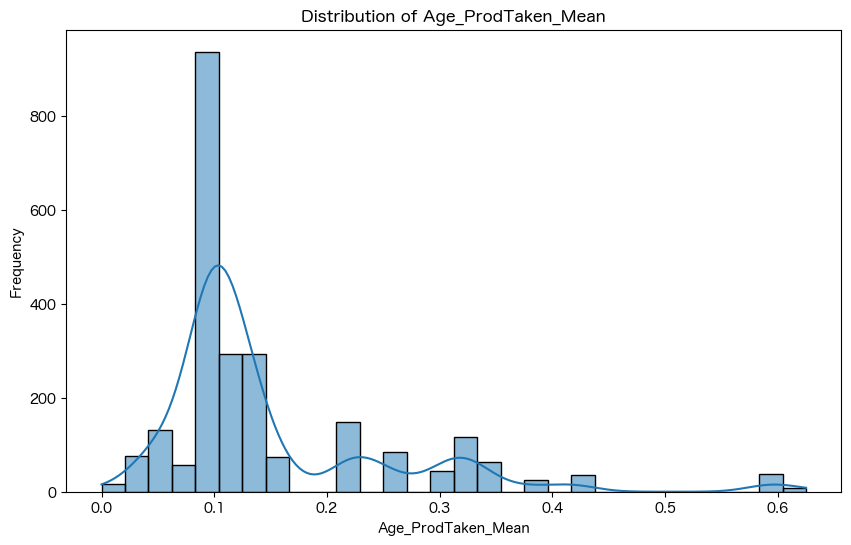

Age_ProdTaken_Bucket
Low          982
Medium       897
Very High    285
High         277
Name: count, dtype: int64


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_add_new_features.csv'
train_data = pd.read_csv(data_path, low_memory=False, dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})

# MonthlyIncomeのヒストグラムをプロット
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Age_ProdTaken_Mean'], bins=30, kde=True)
plt.title('Distribution of Age_ProdTaken_Mean')
plt.xlabel('Age_ProdTaken_Mean')
plt.ylabel('Frequency')
plt.show()

# ビン分割後の各カテゴリのデータポイント数を確認
print(train_data['Age_ProdTaken_Bucket'].value_counts())

## 数値変数を確認する

In [1]:
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_new_features_without_target.csv'
train_data = pd.read_csv(data_path, low_memory=False, dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})

# 数値型の変数のみを抽出
numeric_columns = train_data.select_dtypes(include=['int64', 'float64', 'Int64']).columns

# 数値変数のリストを表示
print("数値変数:")
print(numeric_columns)

print(train_data.info())


数値変数:
Index(['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'MonthlyIncome', 'ProdTaken',
       'MaritalStatus', 'CarCount', 'ChildCount', 'Age_ProdTaken_Mean',
       'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction',
       'Age_DurationOfPitch', 'CityTier_Age', 'CityTier_MonthlyIncome',
       'MonthlyIncome_PerFamily', 'Income_Per_Age', 'Satisfaction_PerVisitor',
       'AverageIncome'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            2989 non-null   int64  
 1   TypeofContact                  2989 non-null   object 
 2   CityTier                       2989 non-null   int64  
 3   DurationOfPitch  

## 相関行列を確認する

Top Correlation Pairs:
Gender_Male                          Gender_Female                    1.000000
TypeofContact_Self Enquiry           TypeofContact_Company Invited    1.000000
AgeGroup_Rank                        AverageIncome                    0.976418
Age_Income_Interaction_Rank          Age_MonthlyIncome_Interaction    0.962728
AgeGroup_Rank                        Age_Bucket_Rank                  0.938033
Designation_PropertyStar             Designation_Rank                 0.935990
Age_Bucket_Rank                      AverageIncome                    0.920792
EngagementScore                      PitchSatisfactionScore           0.889047
Age_ProdTaken_Bucket_Rank            Age_ProdTaken_Mean               0.887576
AgeGroup_Rank                        Age_MonthlyIncome_Interaction    0.862049
AverageIncome                        Age_MonthlyIncome_Interaction    0.857263
Age_Income_Interaction_Rank          Income_Bucket_Rank               0.852061
TotalTrips                   

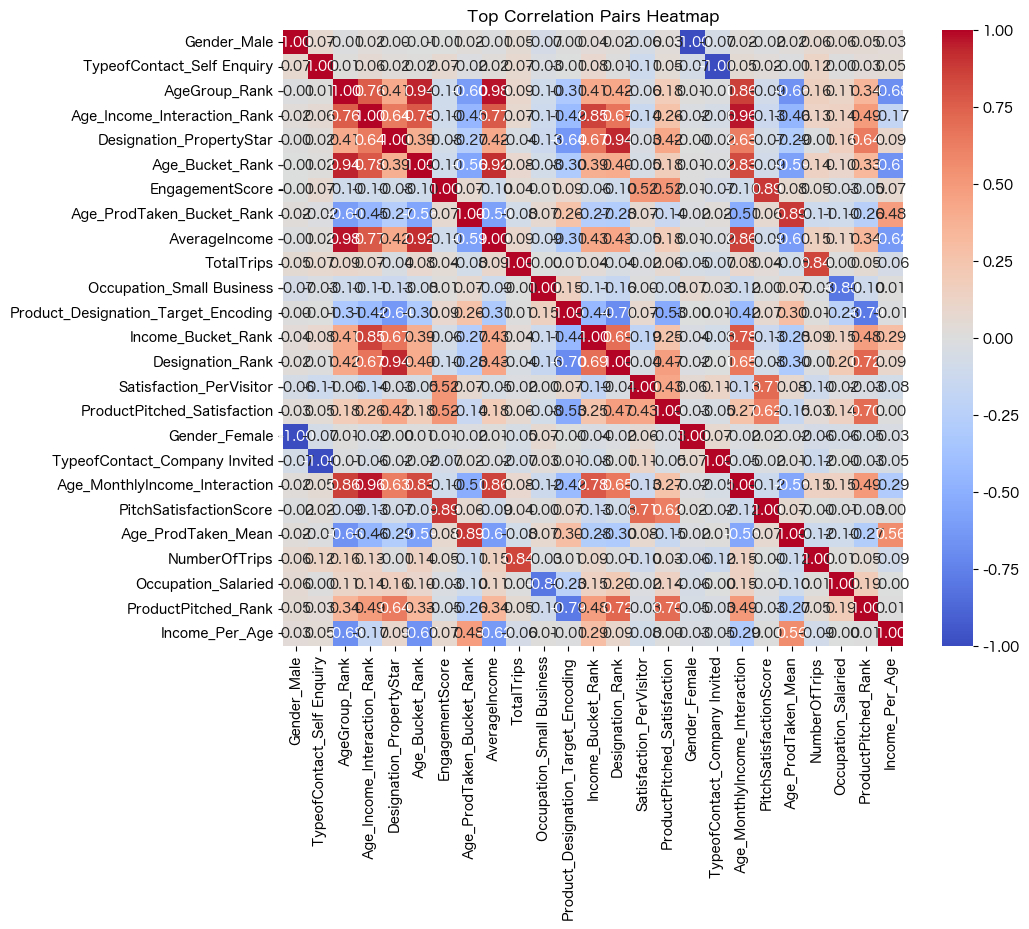

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データファイルを読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_new_features_without_target.csv'
train_data = pd.read_csv(data_path, low_memory=False, dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})

# 数値変数のリスト
numeric_columns = [ 
    'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
    'Passport', 'PitchSatisfactionScore', 'MaritalStatus',
    'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction',
    'CityTier_Age', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'AverageIncome',
    'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank',
    'Age_Bucket_Rank', 'Age_Income_Interaction_Rank', 'Age_ProdTaken_Bucket_Rank',
    'AgeGroup_Rank', 'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry',
    'Occupation_Large Business', 'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female',
    'Gender_Male', 'TotalTrips', 'EngagementScore', 'ProductPitched_Satisfaction',
    'Designation_PropertyStar', 'Product_Designation_Target_Encoding', 
    'CityTier_Age_Income_x_FamilySize_Income', 'ProdTaken'
]

# 数値変数間の相関行列を作成
corr_matrix = train_data[numeric_columns].corr().abs()

# 上三角行列を取得し、相関行列を半分にする
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 相関行列をフラットにして、上位の相関を取得
corr_pairs = upper.unstack()
sorted_pairs = corr_pairs.sort_values(ascending=False)

# 上位30の相関ペアを表示
top_pairs = sorted_pairs.dropna().head(30)
print("Top Correlation Pairs:")
print(top_pairs)

# 相関が強い上位の特徴量をヒートマップで可視化
top_features = pd.Index(top_pairs.index.get_level_values(0).append(top_pairs.index.get_level_values(1))).unique()
top_corr_matrix = train_data[top_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Top Correlation Pairs Heatmap')
plt.show()


## モデルが重視する特徴量を可視化する

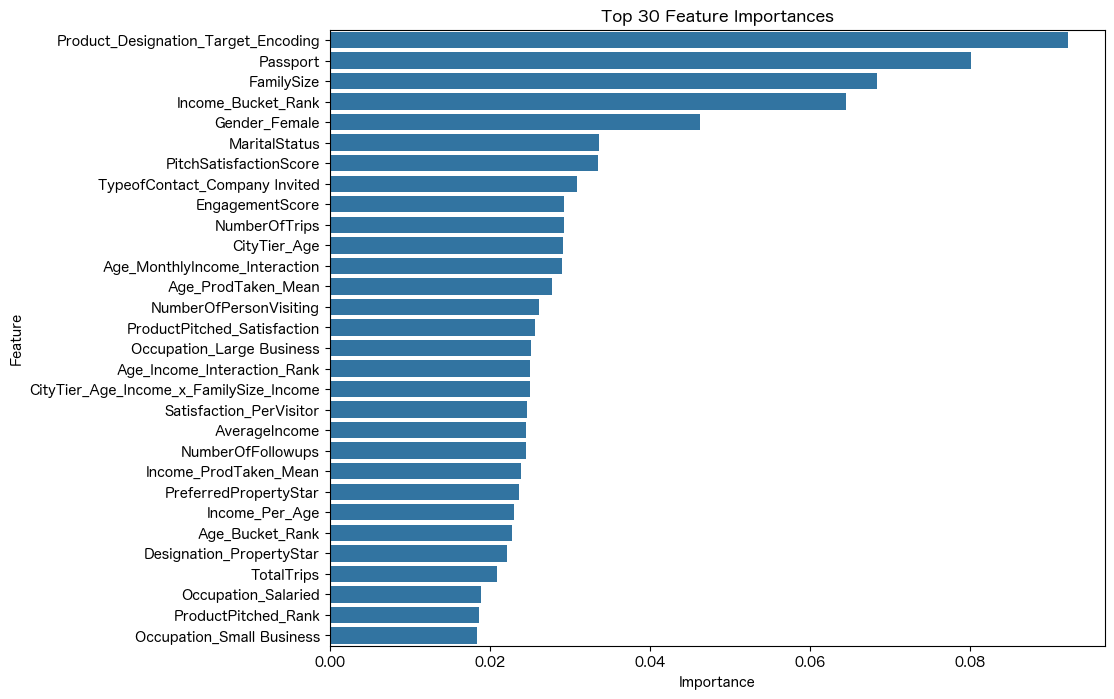

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901.csv'
train_data = pd.read_csv(data_path)

# 数値型の変数のみを抽出
numeric_columns = train_data.select_dtypes(include=['int64', 'float64', 'Int64']).columns

# 特徴量とターゲット変数の設定
X = train_data[numeric_columns].drop('ProdTaken', axis=1)  # 特徴量
y = train_data['ProdTaken']  # 目的変数

# モデルのトレーニング
model = xgb.XGBClassifier(random_state=27)
model.fit(X, y)

# 特徴量重要度の取得
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# 特徴量重要度の降順にソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 特徴量重要度の上位30個をプロット
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(30))
plt.title('Top 30 Feature Importances')
plt.show()


## 相関関係の高い特徴量の一方を削除する

In [83]:
import pandas as pd
import os

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_reduced_TotalTrips.csv'
train_data = pd.read_csv(data_path)

# 削除する特徴量のリスト
columns_to_drop = [
    'CityTier_Age'
]

# 指定した特徴量をデータフレームから削除
train_with_reduced_features = train_data.drop(columns=columns_to_drop)

# ディレクトリが存在するか確認し、存在しない場合は作成
save_dir = '/Users/hayakawakazue/Downloads/signate/train'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 新しい特徴量を含むデータを保存
train_data_path = os.path.join(save_dir, 'train_with_reduced_CityTierAge.csv')
train_with_reduced_features.to_csv(train_data_path, index=False)

print(f"指定した特徴量を削除したデータを保存しました: {train_data_path}")

print(train_with_reduced_features.dtypes)

指定した特徴量を削除したデータを保存しました: /Users/hayakawakazue/Downloads/signate/train/train_with_reduced_CityTierAge.csv
NumberOfPersonVisiting                   int64
NumberOfFollowups                        int64
ProductPitched                          object
PreferredPropertyStar                    int64
NumberOfTrips                            int64
Passport                                 int64
Designation                             object
ProdTaken                                int64
MaritalStatus                            int64
CarCount                                 int64
Age_ProdTaken_Mean                     float64
Income_ProdTaken_Mean                  float64
FamilySize                               int64
Age_MonthlyIncome_Interaction            int64
Income_Bucket                           object
Age_Bucket                              object
Age_Income_Interaction                  object
DurationOfPitch_Category                object
Age_ProdTaken_Bucket                    object
Age

## カテゴリ変数を確認する

In [39]:
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_reduced_features.csv'
train_data = pd.read_csv(data_path, low_memory=False, dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})

# カテゴリ型の変数のみを抽出
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns

# カテゴリ変数のリストを表示
print("カテゴリ変数:")
print(categorical_columns)

# カテゴリ変数のデータを表示（必要に応じて先頭の数行だけ表示）
print("\nカテゴリ変数のデータ:")
print(train_data[categorical_columns].head())


カテゴリ変数:
Index(['TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
       'Designation', 'Income_Bucket', 'Age_Bucket', 'Age_Income_Interaction',
       'DurationOfPitch_Category', 'Age_ProdTaken_Bucket', 'AgeGroup'],
      dtype='object')

カテゴリ変数のデータ:
     TypeofContact      Occupation  Gender ProductPitched     Designation  \
0     Self Enquiry  Large Business    Male          Basic       Executive   
1  Company Invited        Salaried    Male       Standard  Senior Manager   
2     Self Enquiry  Large Business  Female          Basic       Executive   
3     Self Enquiry  Small Business  Female       Standard  Senior Manager   
4  Company Invited  Small Business  Female          Basic       Executive   

  Income_Bucket Age_Bucket Age_Income_Interaction DurationOfPitch_Category  \
0           Low  MiddleOld          MiddleOld_Low                     Long   
1      VeryHigh        Old           Old_VeryHigh                     Long   
2           Low     Middle             Midd

## カテゴリ変数に含まれるユニークなデータを確認する

In [22]:
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_reduced7_features.csv'
train_data = pd.read_csv(data_path, low_memory=False, dtype={'MaritalStatus': 'Int64', 'CarCount': 'Int64', 'ChildCount': 'Int64'})

# Age_Income_Interaction列のユニークな値を確認
print(train_data['Age_Income_Interaction'].unique())


['MiddleOld_Low' 'Old_VeryHigh' 'Middle_Low' 'Middle_Medium'
 'VeryYoung_Low' 'MiddleOld_UltraHigh' 'Middle_VeryLow' 'Old_High'
 'MiddleOld_VeryHigh' 'Old_Low' 'Young_Low' 'VeryYoung_High'
 'Young_UltraHigh' 'MiddleOld_Medium' 'MiddleOld_High' 'Old_UltraHigh'
 'Young_VeryHigh' 'Middle_High' 'Middle_VeryHigh' 'Young_Medium'
 'Young_High' 'Middle_UltraHigh' 'VeryYoung_VeryLow' 'Young_VeryLow'
 'Old_Medium' 'VeryYoung_Medium' 'MiddleOld_VeryLow' 'VeryYoung_UltraHigh'
 'VeryYoung_VeryHigh' 'VeryOld_High' 'Old_VeryLow' 'VeryOld_UltraHigh'
 'VeryOld_Low' 'VeryOld_Medium']


## カテゴリ変数のランク付けを定義する

In [19]:
import pandas as pd
import os

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_new_features_without_target.csv'
train_data = pd.read_csv(data_path)

# 1.ProductPitchedのランク付けを定義
product_pitched_ranks = {
    'Basic': 1,
    'Standard': 2,
    'Deluxe': 3,
    'Super Deluxe': 4,
    'King': 5
}
# ランク付けを行う新しい列を作成
train_data['ProductPitched_Rank'] = train_data['ProductPitched'].map(product_pitched_ranks)

# 2.役職のランク付けを定義
designation_ranks = {
    'VP': 5,
    'AVP': 4,
    'Senior Manager': 3,
    'Manager': 2,
    'Executive': 1
}
# ランク付けを行う新しい列を作成
train_data['Designation_Rank'] = train_data['Designation'].map(designation_ranks)

# 3.Income_Bucketのランク付けを定義
income_bucket_ranks = {
    'VeryLow': 1,
    'Low': 2,
    'Medium': 3,
    'High': 4,
    'VeryHigh': 5,
    'UltraHigh': 6
}
# ランク付けを行う新しい列を作成
train_data['Income_Bucket_Rank'] = train_data['Income_Bucket'].map(income_bucket_ranks)

# 4.Age_Bucketのランク付けを定義
age_bucket_ranks = {
    'VeryYoung': 1,
    'Young': 2,
    'Middle': 3,
    'MiddleOld': 4,
    'Old': 5,
    'VeryOld': 6
}
# ランク付けを行う新しい列を作成
train_data['Age_Bucket_Rank'] = train_data['Age_Bucket'].map(age_bucket_ranks)

# 5-1.Age_Bucketのランク付けを定義
age_bucket_ranks = {
    'VeryYoung': 1,
    'Young': 2,
    'Middle': 3,
    'MiddleOld': 4,
    'Old': 5,
    'VeryOld': 6
}

# 5-2.Income_Bucketのランク付けを定義
income_bucket_ranks = {
    'VeryLow': 1,
    'Low': 2,
    'Medium': 3,
    'High': 4,
    'VeryHigh': 5,
    'UltraHigh': 6
}

# 5-3.Age_Income_Interactionのランク付けを計算する関数
def rank_age_income_interaction(value):
    try:
        # 最初のアンダースコアで分割
        split_index = value.rfind('_')
        age_part = value[:split_index]
        income_part = value[split_index + 1:]
        
        age_rank = age_bucket_ranks[age_part]
        income_rank = income_bucket_ranks[income_part]
        
        return age_rank * income_rank
    except ValueError:
        return np.nan  # 期待外の値があればNaNを返す

# Age_Income_Interactionのランク付けを行う新しい列を作成
train_data['Age_Income_Interaction_Rank'] = train_data['Age_Income_Interaction'].map(rank_age_income_interaction)

# 6.DurationOfPitch_Categoryのランク付けを定義
duration_of_pitch_ranks = {
    'Short': 1,
    'Medium': 2,
    'Long': 3,
    'VeryLong': 4
}
# ランク付けを行う新しい列を作成
train_data['DurationOfPitch_Category_Rank'] = train_data['DurationOfPitch_Category'].map(duration_of_pitch_ranks)


# 7.AgeGroupのランク付けを定義
age_group_ranks = {
    '0-19': 1,
    '20-24': 2,
    '25-29': 3,
    '30-34': 4,
    '35-39': 5,
    '40-44': 6,
    '45-49': 7,
    '50-54': 8,
    '55-59': 9,
    '60-64': 10
}

# ランク付けを行う新しい列を作成
train_data['AgeGroup_Rank'] = train_data['AgeGroup'].map(age_group_ranks)

# ラベルエンコーディングされたデータを含むデータセットを保存
output_path = '/Users/hayakawakazue/Downloads/signate/train/train_mapping.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を含むデータを保存しました: {output_path}")

# 結果を確認
print(train_data.info())


新しい特徴量を含むデータを保存しました: /Users/hayakawakazue/Downloads/signate/train/train_mapping.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            2989 non-null   int64  
 1   TypeofContact                  2989 non-null   object 
 2   CityTier                       2989 non-null   int64  
 3   DurationOfPitch                2989 non-null   int64  
 4   Occupation                     2989 non-null   object 
 5   Gender                         2989 non-null   object 
 6   NumberOfPersonVisiting         2989 non-null   int64  
 7   NumberOfFollowups              2989 non-null   int64  
 8   ProductPitched                 2989 non-null   object 
 9   PreferredPropertyStar          2989 non-null   int64  
 10  NumberOfTrips                  2989 non-null   int64  
 11  Passport                

In [8]:
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_mapping.csv'
train_data = pd.read_csv(data_path)

# カテゴリカル変数のみを抽出
categorical_columns = train_data.select_dtypes(include=['object']).columns

# 抽出したカテゴリカル変数を表示
print("カテゴリカル変数:")
print(categorical_columns)

# カテゴリカル変数のみのデータフレームを表示
print("\nカテゴリカル変数のみのデータ:")
print(train_data[categorical_columns].head())


カテゴリカル変数:
Index(['TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
       'Designation', 'Income_Bucket', 'Age_Bucket', 'Age_Income_Interaction',
       'DurationOfPitch_Category', 'Age_ProdTaken_Bucket', 'AgeGroup'],
      dtype='object')

カテゴリカル変数のみのデータ:
     TypeofContact      Occupation  Gender ProductPitched     Designation  \
0     Self Enquiry  Large Business    Male          Basic       Executive   
1  Company Invited        Salaried    Male       Standard  Senior Manager   
2     Self Enquiry  Large Business  Female          Basic       Executive   
3     Self Enquiry  Small Business  Female       Standard  Senior Manager   
4  Company Invited  Small Business  Female          Basic       Executive   

  Income_Bucket Age_Bucket Age_Income_Interaction DurationOfPitch_Category  \
0           Low  MiddleOld          MiddleOld_Low                     Long   
1      VeryHigh        Old           Old_VeryHigh                     Long   
2           Low     Middle           

## ワンホットエンコーディングを適用する

In [20]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import joblib

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_mapping.csv'
train_data = pd.read_csv(data_path)

# ワンホットエンコーディングを適用するカテゴリ変数
categorical_columns = [
    'TypeofContact', 'Occupation', 'Gender'
]

# OneHotEncoderのインスタンスを作成
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# カテゴリ変数をエンコード
encoded_columns = encoder.fit_transform(train_data[categorical_columns])

# エンコードされた列の名前を取得
encoded_col_names = encoder.get_feature_names_out(categorical_columns)

# エンコードされた列をデータフレームに変換
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_col_names, index=train_data.index)

# オリジナルのデータフレームにエンコードされた列を追加
train_data = train_data.drop(categorical_columns, axis=1)
train_data = pd.concat([train_data, encoded_df], axis=1)

# 特徴量の確認
print(train_data.head())

# 新しい特徴量を含むデータを保存
output_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_onehot_encoded_features.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を含むデータを保存しました: {output_path}")

# エンコーダーを保存
encoder_path = '/Users/hayakawakazue/Downloads/signate/train/onehot_encoder.pkl'
joblib.dump(encoder, encoder_path)
print(f"エンコーダーを保存しました: {encoder_path}")


   Age  CityTier  DurationOfPitch  NumberOfPersonVisiting  NumberOfFollowups  \
0   50         2              900                       1                  4   
1   56         1              840                       1                  4   
2   38         1              600                       1                  3   
3   37         2             1080                       1                  3   
4   48         3             1020                       1                  3   

  ProductPitched  PreferredPropertyStar  NumberOfTrips  Passport  \
0          Basic                      3              5         1   
1       Standard                      3              2         1   
2          Basic                      3              4         0   
3       Standard                      4              1         0   
4          Basic                      4              4         0   

   PitchSatisfactionScore  ... Age_Income_Interaction_Rank  \
0                       4  ...                  

## リストを表示する

In [21]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_onehot_encoded_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 数値型のカラムを抽出
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 数値型カラム名のリストを表示
print("Numerical columns:")
print(numerical_columns)

Numerical columns:
['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'MonthlyIncome', 'ProdTaken', 'MaritalStatus', 'CarCount', 'ChildCount', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'CityTier_Age', 'CityTier_MonthlyIncome', 'MonthlyIncome_PerFamily', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'AverageIncome', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'Age_Bucket_Rank', 'Age_Income_Interaction_Rank', 'DurationOfPitch_Category_Rank', 'AgeGroup_Rank', 'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry', 'Occupation_Large Business', 'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female', 'Gender_Male']


## XGBoostingでモデルが重視する特徴量を確認する

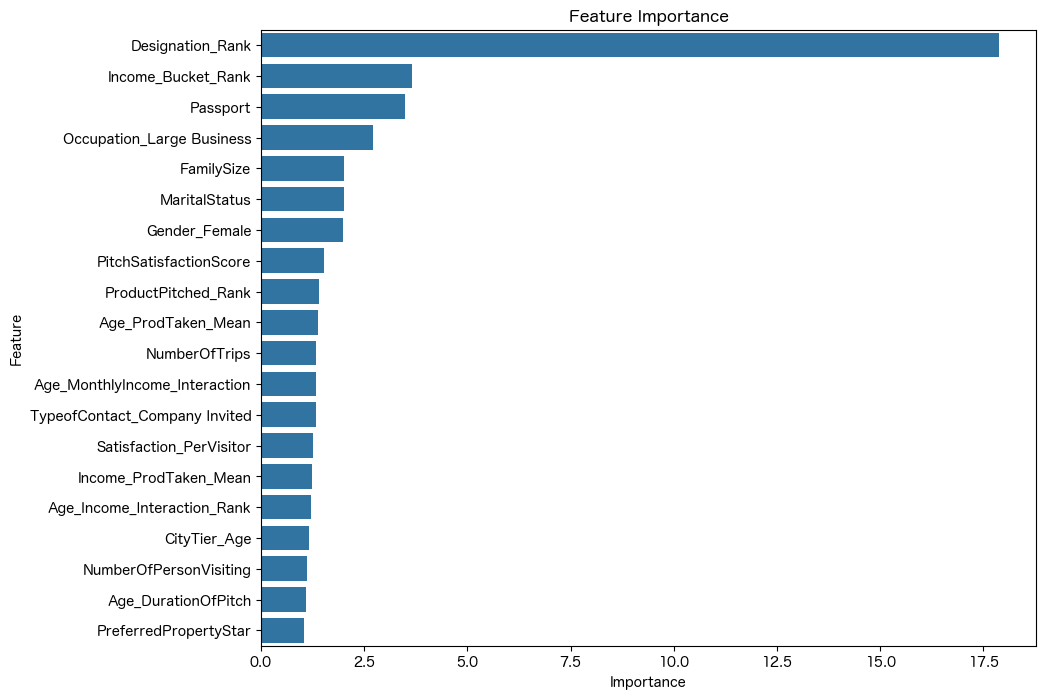

In [30]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0820.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲット変数の分離
X = train_data.drop('ProdTaken', axis=1)
y = train_data['ProdTaken']

# XGBoostモデルのトレーニング
model = xgb.XGBClassifier(eval_metric='logloss')
model.fit(X, y)

# 特徴量の重要度を取得
importance = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': importance.keys(),
    'Importance': importance.values()
})

# 重要度が高い順に並び替え
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 上位20の特徴量を取得
top_20_features = importance_df.head(20)

# プロットの作成
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Feature Importance')
plt.show()


## ランダムフォレストでモデルが重視する特徴量を確認する

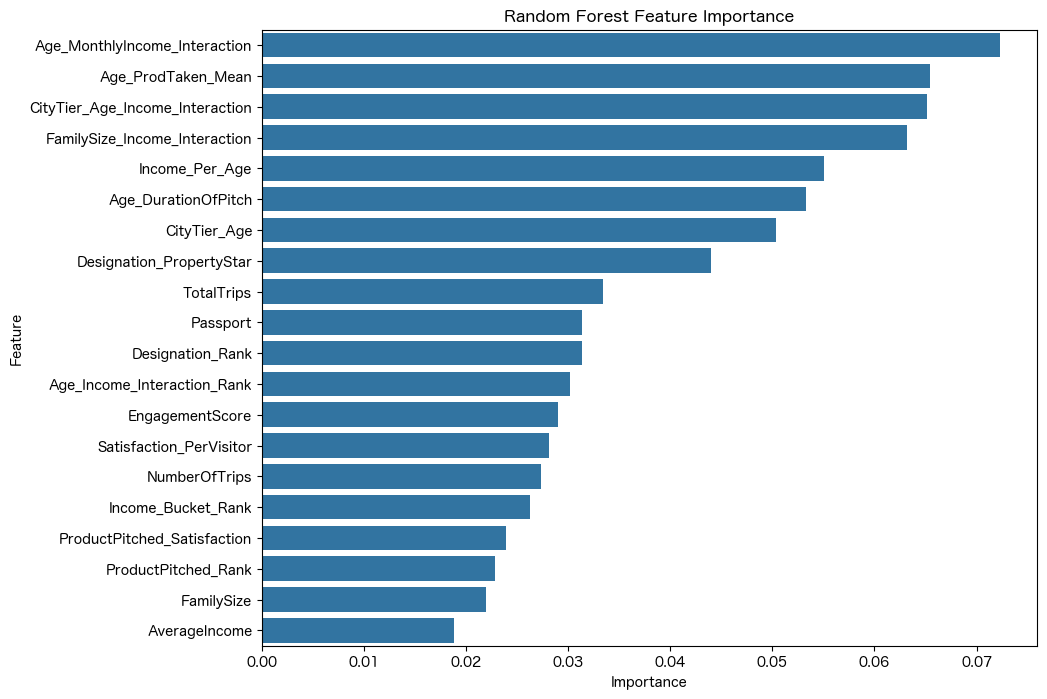

In [26]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0821.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲット変数の分離
X = train_data.drop('ProdTaken', axis=1)
y = train_data['ProdTaken']

# ランダムフォレストモデルのトレーニング
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# 特徴量の重要度を取得
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# 重要度が高い順に並び替え
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 上位20の特徴量を取得
top_20_features = importance_df.head(20)

# プロットの作成
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Random Forest Feature Importance')
plt.show()


## カラム名のリストを表示する

In [21]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_onehot_encoded_features.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 数値型のカラムを抽出
numerical_columns = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 数値型カラム名のリストを表示
print("Numerical columns:")
print(numerical_columns)

print(train_data.info())

Numerical columns:
['NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'MaritalStatus', 'CarCount', 'Age_ProdTaken_Mean', 'Income_ProdTaken_Mean', 'FamilySize', 'Age_MonthlyIncome_Interaction', 'Age_DurationOfPitch', 'CityTier_Age', 'Income_Per_Age', 'Satisfaction_PerVisitor', 'ProductPitched_Rank', 'Designation_Rank', 'Income_Bucket_Rank', 'Age_Bucket_Rank', 'Age_Income_Interaction_Rank', 'DurationOfPitch_Category_Rank', 'Age_ProdTaken_Bucket_Rank', 'AgeGroup_Rank', 'TypeofContact_Company Invited', 'TypeofContact_Self Enquiry', 'Occupation_Large Business', 'Occupation_Salaried', 'Occupation_Small Business', 'Gender_Female', 'Gender_Male']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   NumberOfPersonVisiting         

## 特徴量を追加する

In [22]:
import pandas as pd
import numpy as np

# データを読み込む
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_onehot_encoded_features.csv'
train_data = pd.read_csv(data_path)

# 交互作用特徴量の作成
train_data['CityTier_Age_Income_Interaction'] = train_data['CityTier_Age'] * train_data['Income_Per_Age']
train_data['FamilySize_Income_Interaction'] = train_data['FamilySize'] * train_data['Income_Per_Age']

# 派生特徴量の作成
train_data['TotalTrips'] = train_data['NumberOfTrips'] * train_data['DurationOfPitch_Category_Rank']
train_data['EngagementScore'] = train_data['NumberOfFollowups'] * train_data['PitchSatisfactionScore']

# 行動特徴量の作成
train_data['ProductPitched_Satisfaction'] = train_data['ProductPitched_Rank'] * train_data['PitchSatisfactionScore']
train_data['Designation_PropertyStar'] = train_data['Designation_Rank'] * train_data['PreferredPropertyStar']

# データを保存
output_path = '/Users/hayakawakazue/Downloads/signate/train/train_add_new_features0901_1.csv'
train_data.to_csv(output_path, index=False)
print(f"新しい特徴量を追加したデータを保存しました: {output_path}")


新しい特徴量を追加したデータを保存しました: /Users/hayakawakazue/Downloads/signate/train/train_add_new_features0901_1.csv


## 新しい特徴量の追加

In [23]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_add_new_features0901_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# CityTier_Age_Income_と_FamilySize_Incomeを掛け合わせる
train_data['CityTier_Age_Income_x_FamilySize_Income'] = (
    train_data['CityTier_Age_Income_Interaction'] * 
    train_data['FamilySize_Income_Interaction']
)


# 新しいデータセットの保存
output_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_CityTierAgeIncomeFamilySizeIncome.csv'
train_data.to_csv(output_path, index=False)
print(f"CityTier_Age_Income_x_FamilySize_Incomeを含むデータセットを {output_path} に保存しました。")


CityTier_Age_Income_x_FamilySize_Incomeを含むデータセットを /Users/hayakawakazue/Downloads/signate/train/train_with_CityTierAgeIncomeFamilySizeIncome.csv に保存しました。


In [27]:
import pandas as pd

# pandasの表示設定を変更してすべての列を表示する
pd.set_option('display.max_columns', None)

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_with_CityTierAgeIncomeFamilySizeIncome.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# データの先頭5行を表示
train_data.head()



,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,MaritalStatus,CarCount,ChildCount,FamilySize,Age_MonthlyIncome_Interaction,Income_Bucket,Age_Bucket,Age_Income_Interaction,DurationOfPitch_Category,Age_DurationOfPitch,CityTier_Age,CityTier_MonthlyIncome,MonthlyIncome_PerFamily,Income_Per_Age,Satisfaction_PerVisitor,AgeGroup,AverageIncome,ProductPitched_Rank,Designation_Rank,Income_Bucket_Rank,Age_Bucket_Rank,Age_Income_Interaction_Rank,DurationOfPitch_Category_Rank,AgeGroup_Rank,TypeofContact_Company_Invited,TypeofContact_Self_Enquiry,Occupation_Large_Business,Occupation_Salaried,Occupation_Small_Business,Gender_Female,Gender_Male,CityTier_Age_Income_Interaction,FamilySize_Income_Interaction,TotalTrips,EngagementScore,ProductPitched_Satisfaction,Designation_PropertyStar,CityTier_Age_Income_x_FamilySize_Income
0,50,2,900,1,4,Basic,3,5,1,4,Executive,253905,1,0,1,0,1,12695250,Low,MiddleOld,MiddleOld_Low,Long,45000,100,507810,253905.0,5078.100000,4.0,50-54,393361.086957,1,1,2,4,8,3,8,0.0,1.0,1.0,0.0,0.0,0.0,1.0,507810.0,5078.100000,15,16,4,3,2.578710e+09
1,56,1,840,1,4,Standard,3,2,1,4,Senior Manager,404475,0,0,1,0,1,22650600,VeryHigh,Old,Old_VeryHigh,Long,47040,56,404475,404475.0,7222.767857,4.0,55-59,416052.500000,2,3,5,5,25,3,9,1.0,0.0,0.0,1.0,0.0,0.0,1.0,404475.0,7222.767857,6,16,8,9,2.921429e+09
2,38,1,600,1,3,Basic,3,4,0,4,Executive,278145,1,1,1,0,2,10569510,Low,Middle,Middle_Low,Medium,22800,38,278145,139072.5,7319.605263,4.0,35-39,334243.477509,1,1,2,3,6,2,5,0.0,1.0,1.0,0.0,0.0,1.0,0.0,278145.0,14639.210526,8,12,4,3,4.071823e+09
3,37,2,1080,1,3,Standard,4,1,0,5,Senior Manager,326805,0,0,1,0,1,12091785,Medium,Middle,Middle_Medium,VeryLong,39960,74,653610,326805.0,8832.567568,5.0,35-39,334243.477509,2,3,3,3,9,4,5,0.0,1.0,0.0,0.0,1.0,1.0,0.0,653610.0,8832.567568,4,15,10,12,5.773054e+09
4,48,3,1020,1,3,Basic,4,4,0,4,Executive,258435,1,0,1,0,1,12404880,Low,MiddleOld,MiddleOld_Low,VeryLong,48960,144,775305,258435.0,5384.062500,4.0,45-49,373757.491749,1,1,2,4,8,4,7,1.0,0.0,0.0,0.0,1.0,1.0,0.0,775305.0,5384.062500,16,12,4,4,4.174291e+09


## スケーリングを適用する

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# ProdTaken列をスケーリングから除外
y_train = train_data['ProdTaken']
X_train = train_data.drop(columns=['ProdTaken'])

# スケーリングを行うカラムを指定
columns_to_scale = [
    'Visits_to_Income_Ratio', 'Family_Income_Stability_Index', 'Pitch_Effectiveness_Index',
    'CityTier_Age_NumberOfPersonVisiting', 'MaritalStatus_Income_Interaction', 'CityTier_Income_Ratio' 
]

# スケーリング対象の列が存在するか確認
missing_columns = [col for col in columns_to_scale if col not in X_train.columns]
if missing_columns:
    print(f"以下のカラムがデータに存在しません: {missing_columns}")
else:
    # 無限大の値や非常に大きな値の処理を各カラムで個別に行う
    for col in columns_to_scale:
        X_train[col] = X_train[col].replace([np.inf, -np.inf], np.nan)

    # NaN値を平均で補完
    for col in columns_to_scale:
        X_train[col] = X_train[col].fillna(X_train[col].mean())

    # StandardScalerのインスタンスを作成してスケーリング
    scaler = StandardScaler()
    X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

    # スケーリング後にProdTaken列を再度結合
    train_scaled = pd.concat([X_train, y_train], axis=1)

    # データの保存
    output_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled0901_2.csv'
    train_scaled.to_csv(output_path, index=False)
    print(f"ProdTaken列を保持したままスケーリング済みのデータを保存しました: {output_path}")

    # スケーラーの保存
    scaler_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"スケーラーを保存しました: {scaler_path}")


ProdTaken列を保持したままスケーリング済みのデータを保存しました: /Users/hayakawakazue/Downloads/signate/train/train_scaled0901_2.csv
スケーラーを保存しました: /Users/hayakawakazue/Downloads/signate/train/train_scaler.pkl


## データ型の確認

In [10]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled.csv'
train_data = pd.read_csv(data_path, low_memory=False)

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 50 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   NumberOfPersonVisiting                   2989 non-null   float64
 1   NumberOfFollowups                        2989 non-null   int64  
 2   ProductPitched                           2989 non-null   object 
 3   PreferredPropertyStar                    2989 non-null   float64
 4   NumberOfTrips                            2989 non-null   int64  
 5   Passport                                 2989 non-null   int64  
 6   PitchSatisfactionScore                   2989 non-null   float64
 7   Designation                              2989 non-null   object 
 8   MaritalStatus                            2989 non-null   int64  
 9   CarCount                                 2989 non-null   int64  
 10  Age_ProdTaken_Mean                       2989 no

## 不要なobject型の列を削除する

In [31]:
import pandas as pd
import numpy as np

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 不要な列を削除
train_data = train_data.drop(columns=[
    'ProductPitched', 'Designation', 'Income_Bucket', 'Age_Bucket',
    'Age_Income_Interaction', 'DurationOfPitch_Category','AgeGroup',
    'CarCount', 'Age_DurationOfPitch', 'DurationOfPitch_Category_Rank',
    'CityTier_Age_Income_Interaction', 'FamilySize_Income_Interaction'
])

# データ型の確認
print(train_data.info())

# データの保存
output_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_1.csv'
train_data.to_csv(output_path, index=False)
print(f"不要な列を削除してデータを保存しました: {output_path}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2989 entries, 0 to 2988
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Age                                      2989 non-null   float64
 1   CityTier                                 2989 non-null   float64
 2   DurationOfPitch                          2989 non-null   float64
 3   NumberOfPersonVisiting                   2989 non-null   float64
 4   NumberOfFollowups                        2989 non-null   float64
 5   PreferredPropertyStar                    2989 non-null   float64
 6   NumberOfTrips                            2989 non-null   float64
 7   Passport                                 2989 non-null   int64  
 8   PitchSatisfactionScore                   2989 non-null   float64
 9   MonthlyIncome                            2989 non-null   float64
 10  MaritalStatus                            2989 no

## モデルが重要とする特徴量を可視化する

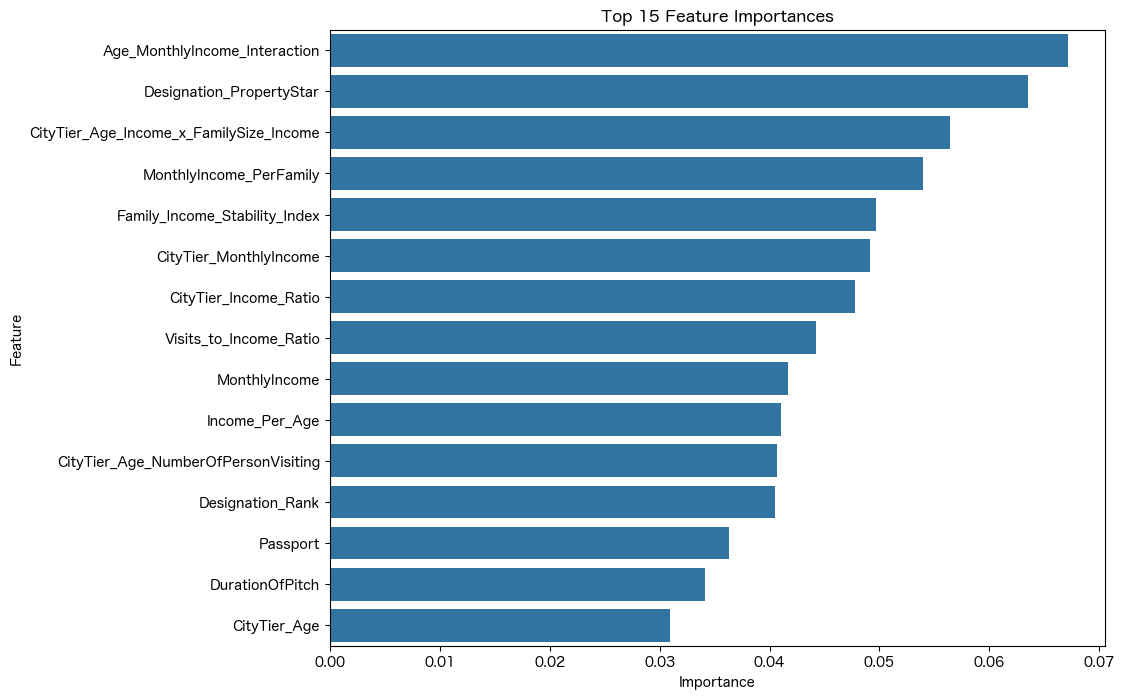

In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# トレインデータの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_scaled0901_2.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量とターゲットの分割
X = train_data.drop(columns=['ProdTaken'])
y = train_data['ProdTaken']

# 無限大または非常に大きな値を処理
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# 欠損値を持つ行を削除（特徴量とターゲットの両方）
non_na_indices = X.dropna().index
X = X.loc[non_na_indices]
y = y.loc[non_na_indices]

# ランダムフォレスト回帰モデルのインスタンスを作成
model = RandomForestRegressor(random_state=24)

# モデルのトレーニング
model.fit(X, y)

# 特徴量重要度の取得
feature_importances = model.feature_importances_
feature_names = X.columns

# データフレームに変換
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# 重要度の降順に並べ替え
importance_df = importance_df.sort_values('importance', ascending=False)

# 上位15の特徴量を取得
top_15_features = importance_df.head(15)

# 可視化
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_15_features)
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


## 新しい特徴量の候補

In [33]:
import pandas as pd
import numpy as np
import os

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/train/train_proceed_0901_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 新しい特徴量の作成
train_data['Visits_to_Income_Ratio'] = train_data['NumberOfPersonVisiting'] / (train_data['MonthlyIncome'] + 1)
train_data['Family_Income_Stability_Index'] = train_data['MonthlyIncome'] / (train_data['FamilySize'] + 1)
train_data['Pitch_Effectiveness_Index'] = train_data['PitchSatisfactionScore'] * train_data['NumberOfFollowups']
train_data['CityTier_Age_NumberOfPersonVisiting'] = train_data['CityTier_Age'] * train_data['NumberOfPersonVisiting']
train_data['MaritalStatus_Income_Interaction'] = train_data['MaritalStatus'] * train_data['MonthlyIncome']
train_data['CityTier_Income_Ratio'] = train_data['CityTier_Age'] / (train_data['MonthlyIncome'] + 1)

# 新しい特徴量を確認
print(train_data.head())

# ディレクトリが存在するか確認し、存在しない場合は作成
save_dir = '/Users/hayakawakazue/Downloads/signate/train'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# データを保存
train_data_path = os.path.join(save_dir, 'train_proceed_0901_2.csv')
train_data.to_csv(train_data_path, index=False)

print(f"新しい特徴量を作成しデータを保存しました: {train_data_path}")


        Age  CityTier  DurationOfPitch  NumberOfPersonVisiting  \
0  1.160090  0.444171         0.535139               -1.895714   
1  1.769262 -1.037557         0.310423               -1.895714   
2 -0.058254 -1.037557        -0.588442               -1.895714   
3 -0.159783  0.444171         1.209287               -1.895714   
4  0.957033  1.925900         0.984571               -1.895714   

   NumberOfFollowups  PreferredPropertyStar  NumberOfTrips  Passport  \
0           0.402959              -0.755654       1.067281         1   
1           0.402959              -0.755654      -0.653070         1   
2          -0.917703              -0.755654       0.493831         0   
3          -0.917703               0.903897      -1.226520         0   
4          -0.917703               0.903897       0.493831         0   

   PitchSatisfactionScore  MonthlyIncome  MaritalStatus  ChildCount  \
0                1.336650      -1.388328              0           0   
1                1.336650   